# CMPE 255 Project - Team 8
## References
* Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
* Sample/starter code: https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15.ipynb

In [5]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

In [46]:
train = pd.read_csv('https://raw.githubusercontent.com/ushukkla/nospammers/master/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/ushukkla/nospammers/master/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

## Visualization

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

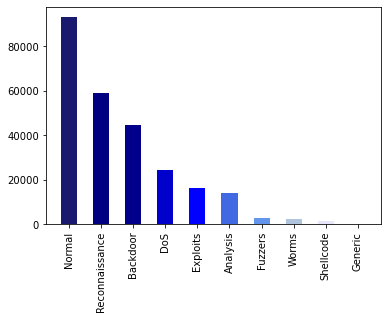

In [47]:
plt.bar(combined_data.attack_cat.unique(),
        combined_data.attack_cat.value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['midnightblue',
               'navy',
               'darkblue',
               'mediumblue',
               'blue', 
               'royalblue', 
               'cornflowerblue', 
               'lightsteelblue', 
               'lavender', 
               'lightskyblue'])
plt.xticks(rotation='vertical')
plt.show()

([<matplotlib.patches.Wedge at 0x7fe10695bf10>,
 [Text(0.4654704967072229, 0.996663040698877, 'Normal'),
  Text(-1.0866279471333316, 0.1709962119720845, 'Reconnaissance'),
  Text(-0.4945025009453456, -0.9825819439409615, 'Backdoor'),
  Text(0.40004113575353367, -1.0246790178904919, 'DoS'),
  Text(0.8387714234046985, -0.7116617871430616, 'Exploits'),
  Text(1.0393251377247725, -0.3602821923067843, 'Analysis'),
  Text(1.090644197435221, -0.14316156816996317, 'Fuzzers'),
  Text(1.097345720968709, -0.07636994612846441, 'Worms'),
  Text(1.0997174710924, -0.024929576292758538, 'Shellcode'),
  Text(1.0999975248432161, -0.0023335249727840894, 'Generic')],
 [Text(0.25389299820393973, 0.5436343858357511, '36.09%'),
  Text(-0.5927061529818171, 0.09327066107568245, '22.85%'),
  Text(-0.2697286368792794, -0.5359537876041608, '17.28%'),
  Text(0.2182042558655638, -0.5589158279402682, '9.41%'),
  Text(0.4575116854934718, -0.3881791566234881, '6.35%'),
  Text(0.5669046205771486, -0.19651755944006416, 

Text(0.5, 1.0, 'Distribution')

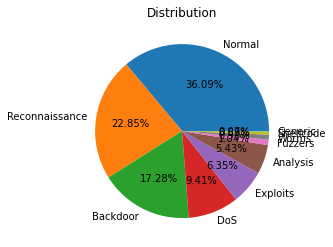

In [54]:
plt.pie(combined_data.attack_cat.value_counts(), labels=combined_data.attack_cat.unique(), autopct='%1.2f%%')
plt.title('Distribution')
plt.savefig('distribution_pie_chart.png')
plt.show()

## Preprocessing

In [43]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.55
test  contamination  0.68 

contamination is 0.55, which is greater than 0.5. Fixing...
contamination is now 0.45


In [44]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector)*100,"%")

attack cat: {'Exploits', 'Normal', 'Analysis', 'Generic', 'Shellcode', 'Fuzzers', 'Reconnaissance', 'DoS', 'Worms', 'Backdoor'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, ['Normal']
mode 36.09225646458884 %
